# Gaussian Processes and infinite Neural Nets

Gaussian Processes (GPs) generalize the Gaussian distributions to situations where the random variable can be regarded as a function. As such, they are a powerful tool for regression and Bayesian inference. In the last years they have received increased attention with the renewed interest in machine learning. I found one connection particularly interesting. At a seminar, I once heard that Gaussian processes could be regarded as infinite Neural Networks. I always wondered about this connection, and so I want to explore it in this article. 

## Introduction

Before we get started, we need to introduce GPs and motivate their use. To do so, we start with a short introduction of multivariate Gaussians and conditional Gaussians as we will make heavy use of them. Readers familiar with the topic may want to skip the introduction.

### Multinomial Gaussian distributions

We introduce the multivariate Gaussian distribution, which is defined as

$$\mathcal{N}(x | \mu, \Sigma) = \frac{1}{\sqrt{ (2 \pi)^d |\Sigma|}} \exp \left\{ - \frac{1}{2} (x - \mu)^T \, \Sigma^{-1} \, (x - \mu)\right\}.$$

The parameters of the distribution are the mean $\mu \in \mathbb{R}^d$ and the covariance matrix $\Sigma \in \mathbb{R}^{d \times d}$. We can restrict our analysis to symmetric positive definite matrices $\Sigma$, as the antisymmetric part of $\Sigma$ does not contribute to the quadric form in the exponent.

In Julia, we can make use of the `Distributions` package to define our multivariate Gaussian:

In [215]:
using Random, Distributions, LinearAlgebra
Random.seed!(123) # this sets the random seed to 123, so that our code becomes reproducible
using Plots # for plotting
theme(:vibrant)

In [216]:
d = 2
μ = Random.randn(d)
X = Random.randn(d, d)
Σ = X'*X

dist = MvNormal(μ, Σ)

FullNormal(
dim: 2
μ: [1.1902678809862768, 2.04817970778924]
Σ: [1.5167137980972474 -0.7586450344468244; -0.7586450344468244 0.5991970596857172]
)


We can visualize the resulting distribution and sample from it. Here, the syntax `(x,y)->Distributions.pdf(dist,[x,y])` extracts the PDF of the distribution in its functional form.

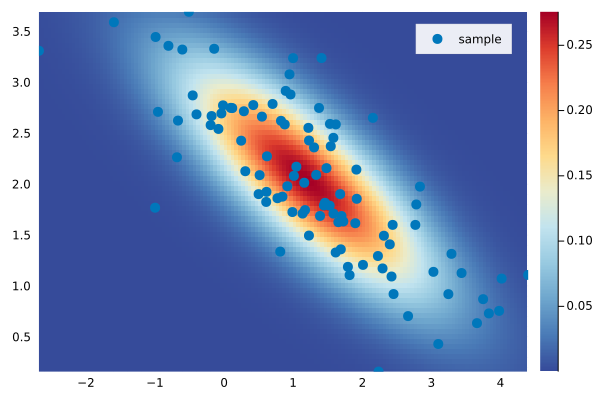

In [217]:
n = 100
x = rand(dist, n)

xmin = min(x[1,:]...)
xmax = max(x[1,:]...)
ymin = min(x[2,:]...)
ymax = max(x[2,:]...)

heatmap(xmin:0.05:xmax, ymin:0.05:ymax, (x,y)->Distributions.pdf(dist,[x,y]))
scatter!(x[1,:], x[2,:], label="sample", xlims = (xmin, xmax), ylims = (ymin, ymax))

### Conditional Gaussians

Let us discuss conditional distributions. We stick to the common practice of distinguishing between random variables denoted by capital letters and their actual realizations denoted by lowercase letters. Assume $X \sim \mathcal{N}(x | \mu, \Sigma)$, where we have observed the first $k$ components $x_1, x_2, \dots, x_k$ of $X$. We are interested in knowing the conditional contribution $p(x_{k+1}, \dots, x_d | x_1, \dots, x_k)$ for the remaining, unobserved variables. For this purpose, let us partition the covariance matrix and the mean according to the variables:

$$
x = \begin{bmatrix}
    x_a \\
    x_b
    \end{bmatrix},
\qquad
\mu = \begin{bmatrix}
    \mu_a \\
    \mu_b
    \end{bmatrix},
\qquad
\Sigma = \begin{bmatrix}
    \Sigma_{aa} & \Sigma_{ab} \\
    \Sigma_{ba} & \Sigma_{bb}
    \end{bmatrix}.
$$

Here, the subscript $a$ corresponds to the first $k$ entries, which are the observed entries, whereas $b$ corresponds to the remaining $d-k$ entries. One can show that the conditional distribution $p(x_{k+1}, \dots, x_d | x_1, \dots, x_k) = p(x_b | x_a)$ is a multinomial Gaussian itself, i.e. 

$$
p(x_b | x_a) = \mathcal{N}(x_b | \mu_{b|a}, \Sigma_{b|a}),
$$

where $\mu_{b|a}, \Sigma_{b|a}$ are the parameters of the conditional distribution. By inserting the partitioned variables and re-shuffling the terms in the exponent, we find that $\mu_{b|a}$ is determined by the conditioned mean

$$
\mu_{b|a} = \mu_b + \Sigma_{ba} \Sigma_{aa}^{-1} (x_a - \mu_a)
$$

and conditioned co-variance matrix

$$
\Sigma_{b|a} = \Sigma_{bb} - \Sigma_{ba} \Sigma_{aa}^{-1} \Sigma_{ab}.
$$

The attentive reader may recognise this as the Schur complement, which appears when the blocked covariance matrix $\Sigma$ is factored and the degrees of freedom corresponding to $a$ are factored out.

## Gaussian Processes as generalizations of Gaussian distributions

Now that we have seen how the Gaussian distribution is generalized to $d$ dmensions, we may ask: "What if the random variable was a function?" This is where Gaussian Processes come in.

### Definition

### Radial basis kernel

An example of a Kernel function is the radial-basis function (RBF) kernel

$$
K(x,x') = \exp \left\{ - \frac{1}{2\sigma^2} ||x - x'||^2\right\},
$$

where $\sigma$ is some parameter controlling the width of the kernel. Due to Julia's functional nature, defining the RBF kernel is straight-forward:

In [218]:
K(xa, xb; σ=1.) = exp.(- [norm(a).^2 for a in (xa .- xb)] ./ (2.0 * σ^2)) # RBF kernel

K (generic function with 2 methods)

Let us visualize the kernel function:

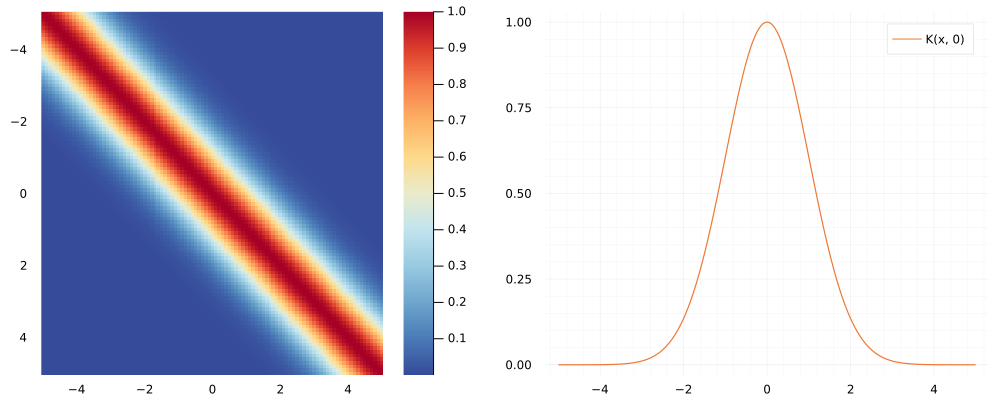

In [219]:
function visualize_kernel(kernel)
  plot1 = heatmap(-5:0.1:5, -5:0.1:5, kernel, yflip = true)

  xa = collect(-5:0.05:5)
  xb = zero(xa)
  plot2 = plot(xa, kernel(xa, xb), label="K(x, 0)")

  plot(plot1, plot2, layout = @layout([a{1.0h} b]), size=(1000,400))
end

visualize_kernel(K)

The figure on the right illustrates the kernel function $K(0, x')$ at a fixed location $x=0$. By varying $x$, we slide the kernel across the domain of $x'$. With respect to the covariance matrix $k(x_i,x_j)$, this implies that the covariance for any two points of our GP falls off exponentially with the distance squared.

What does this mean? Let us illustrate some realizations of this GP, i.e.

$$
f(x) \sim GP(m(x), K(x,x')).
$$

Observing realizations of this Gaussian Process is as easy as picking $n$ points on the real axis $(x_1, x_2, \dots, x_n)^T$ and observing $f(x_i)$ at these points. To simplify this, we set $m(x) = 0$. By the definition of GPs, we have that $(f(x_1), f(x_2), \dots, f(x_n))^T \sim \mathcal{N}(0, S)$. In other words, we need to sample $n$ observations from the multivariate Gaussian $\mathcal{N}(0, S)$, where the covariance matrix $S$ is defined by $S_{ij} = K(x_i, x_j)$. The following code samples $10$ realizations from the Gaussian process defined by $m(x) = 0$ and the radial-basis kernel $K$.

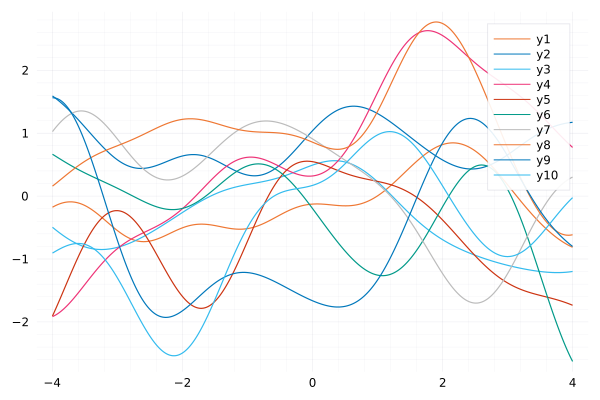

In [220]:
function visualize_gp_samples(mean, kernel, nsamples; bounds=(0,1))
  mesh = LinRange(bounds[1], bounds[2], 500)

  S = [kernel(xa,xb) for xa in mesh, xb in mesh]
  # The following line is a fix to make sure that S is positive definite.
  # To do so, we define a threshhold tol and add the identity matrix to make this the new minimum eigenvalue.
  if !isposdef(S)
    S = S + (1e-12 -  min(eigvals(S)...)) * I
  end
  GP = MvNormal(mean(mesh), S) # this is the workaround

  # sampling the distribution gives us divverent instance of the random variable f
  samples = rand(GP,nsamples)
  plot(mesh,samples)
end

visualize_gp_samples(zero, K, 10, bounds=(-4,4))


We observe that the $10$ samples are smooth functions varying around the mean $0$. This is nice, as we have effectively created a distribution over some function space. For now, we are nto concerned with the precise properties of this function space. Rather, let us explore some other kernel functions.

### Ornstein-Uhlenbeck process

Let us use Lagrange function, which resembles the functional form of the PDF that produces white noise. It is defined as

$$
K(x,x') = \exp \left\{ - \frac{||x - x'||}{l}\right\},
$$

In [221]:
K(xa, xb; l=1.) = exp.(- [norm(a) for a in (xa .- xb)] ./ l) 

K (generic function with 2 methods)

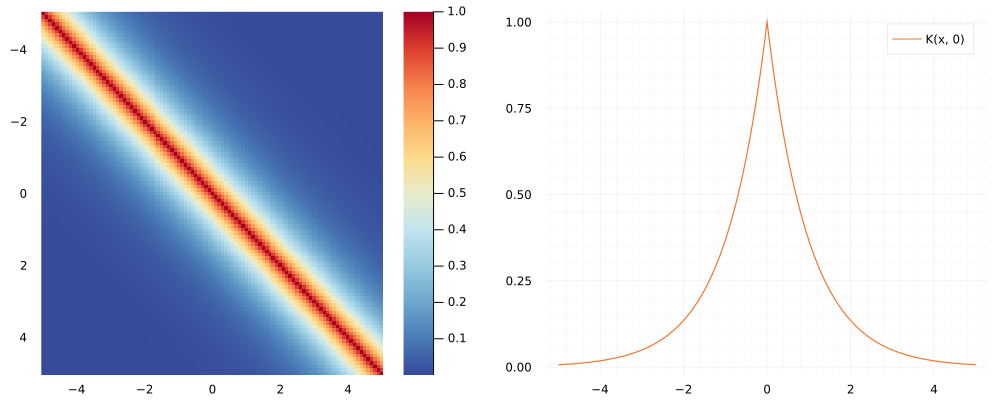

In [222]:
visualize_kernel(K)

We observe that the kernel function is sharply peaked around $x'=0$. We use the same code as before to sample the Gaussian Process:

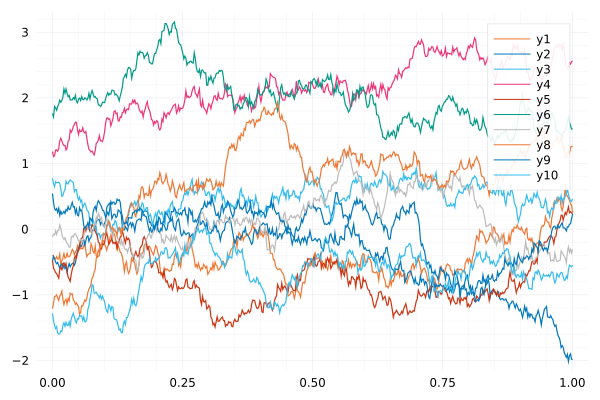

In [223]:
visualize_gp_samples(zero, K, 10)

The resulting functions resemble a stochastic process, and indeed, one can show that the realizations that we observe are equivalent to the random walk of a Brownian particle subject to friction. This is also known as the *Ornstein-Uhlenbeck process*.

## GP regression

Now that we have seen some examples of GPs, we are interested in what we can do with them. A powerful application for GPs is regression. Let us assume that we are observing a function $f(x)$. Instead of observing $f(x)$ directly however, we observe $y = f(x) + \epsilon$ where $\epsilon \sim \mathcal{N}(0, \sigma^2)$ is a noise variable that adds some noise to the observation. We could model this by prescribing the conditional distribution $p(y|x) \sim \mathcal{N}(y | f(x), \sigma^2)$. Alternatively, we could interpret this as a Gaussian process

$$
y \sim GP(f(x), \sigma^2 \delta(x-x'))
$$

where $\delta(x-x')$ is the Dirac delta. This implies that the noise variables are uncorrelated for $x \neq x'$, as the covariance matrix will be diagonal. Let us make this more concrete. We choose $f(x) = \sin (\pi x)$ and $\sigma^2 = $

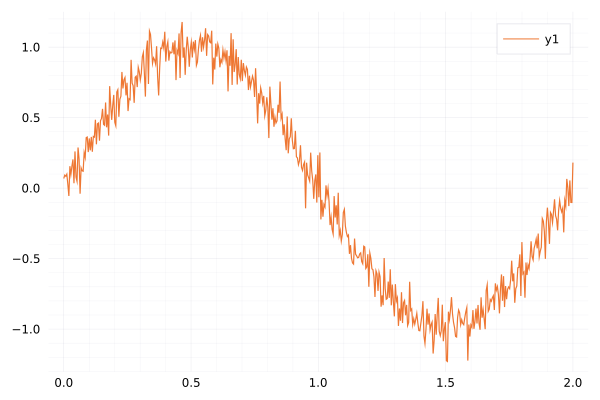

In [236]:
D(xa, xb; σ=0.1) = σ^2 .* [Float64(norm(a) == 0.) for a in (xa .- xb)]
# visualize_kernel(D)
f(x) = sin.(π * x)
visualize_gp_samples(f, D, 1, bounds=(0,2))

## Connection to Neural Networks

[![Illustration of single layer articial neural network](./images/single_layer_ann.svg)](https://en.wikipedia.org/wiki/Artificial_neural_network)

Illustration of a feed-forward neural network (source: https://en.wikipedia.org/wiki/Artificial_neural_network).

## Conclusion



## References

- Nocedal, J., & Wright, S. (2006). *Numerical optimization.* Springer Science & Business Media.
- [en.wikipedia.org/wiki/Gaussian_process](https://en.wikipedia.org/wiki/Gaussian_process) (as opened 22.12.2021).
- [en.wikipedia.org/wiki/Ornstein–Uhlenbeck_process](https://en.wikipedia.org/wiki/Ornstein–Uhlenbeck_process) (as opened 22.12.2021).